# HW 2: Agriculture-Vision Challenge: Weed Cluster Detection

This notebook contains an implementation of machine learning to detect weed clusters in aerial farmland imagery using kNN (K-Nearest Neighbors).

Dataset: Agriculture-Vision 2021
- Positives: 5,941 images with weed clusters
- Negatives: 17,823 images without weed clusters
- Image size: 512 x 512 pixels

## Imports/Setup

In [13]:
#incase seaborn isn't installed
!pip install seaborn

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import os 
from skimage import io, transform, exposure
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image

np.random.seed(42) # for reproducibility
'''
Without setting a random seed:
-Every time you run your code, you get different random numbers
-train/test split will be different each time
-Cross-validation folds will be different
-Results will vary between runs
-You can't reproduce your exact results later'''

warnings.filterwarnings('ignore') #improves readability by hiding warnings lol

print("All imports successful.")

All imports successful.


## Need to load data --> image paths and their respective labels

In [15]:
datadirectory = Path('..') / 'data' #go up one level from src/ to project root
imagedir = datadirectory / 'images' / 'nir'
labeldir = datadirectory / 'labels'

#positives & negatives:
with open(labeldir / 'weed_cluster_positives.txt', 'r') as f:
    positives = [line.strip() for line in f.readlines()]
with open(labeldir / 'weed_cluster_negatives.txt', 'r') as f:
    negatives = [line.strip() for line in f.readlines()]

print(f"Positive examples (weed clusters present): {len(positives)}")
print(f"Negative examples (weed clusters absent): {len(negatives)}")
print(f"Total examples: {len(positives) + len(negatives)}")
print(f"Class Balance: ~{len(positives) / (len(positives) + len(negatives)):.2%} positives") # tells us the proportion of positive examples

#need to make a dataframe to hold image paths and labels
data = []
for img in positives:
    data.append({'image_name': img, 'label': 1}) #1 for positive
for img in negatives:
    data.append({'image_name': img, 'label': 0}) #0 for negative

df = pd.DataFrame(data)
print(f"Dataframe shape: {df.shape}")
df.head()

Positive examples (weed clusters present): 5941
Negative examples (weed clusters absent): 17823
Total examples: 23764
Class Balance: ~25.00% positives
Dataframe shape: (23764, 2)


,image_name,label
0,WVLNWZ83A_1535-5667-2047-6179,1
1,MX3UU7XX7_2339-3942-2851-4454,1
2,BJBU3KDQH_5366-1750-5878-2262,1
3,1FPBNGD9F_4812-1890-5324-2402,1
4,VJ2AGCK2I_1662-4115-2174-4627,1


## Exploration of dataset

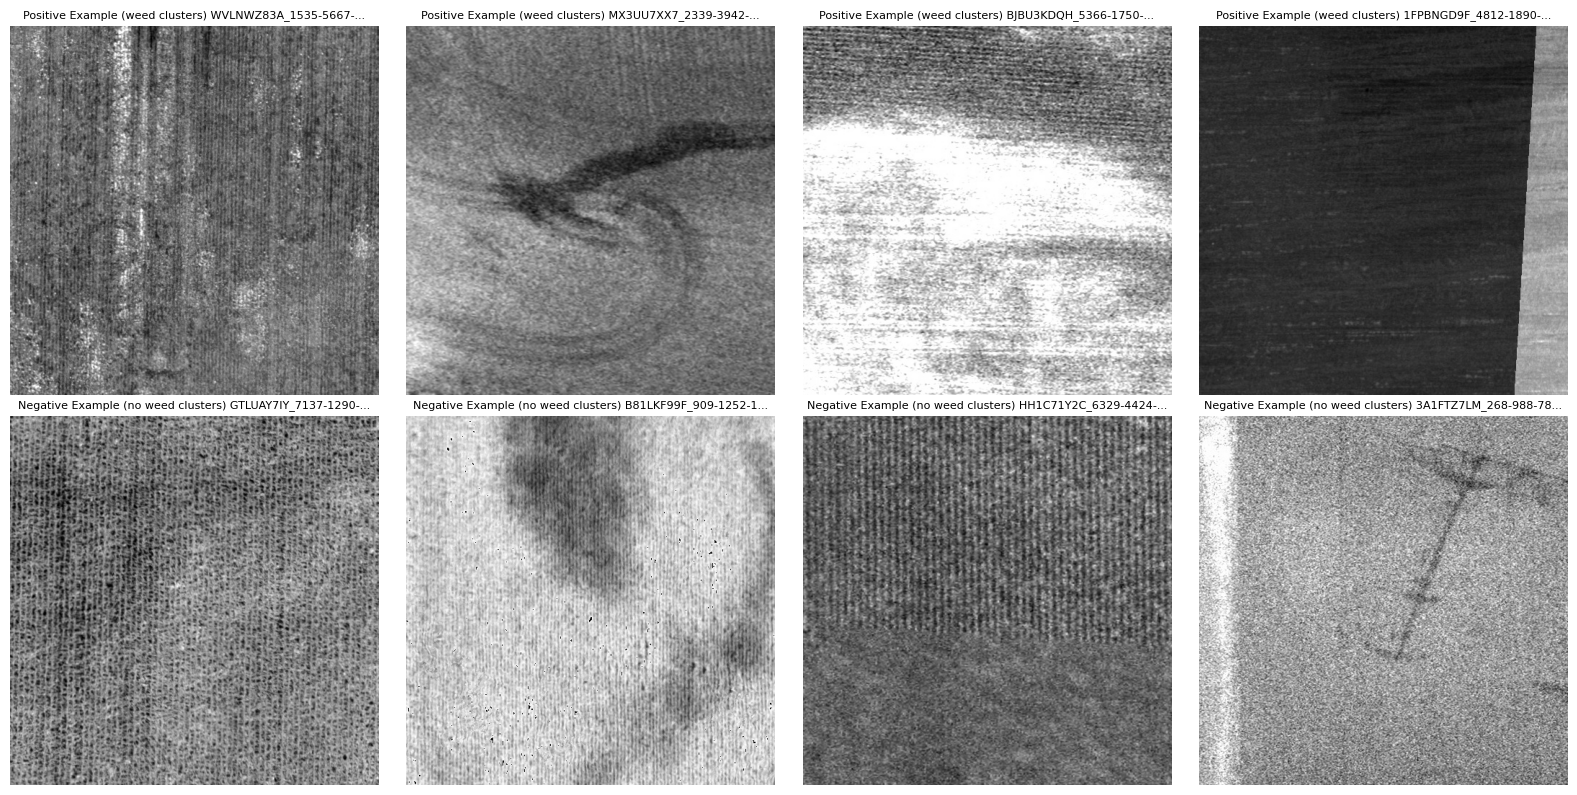

In [16]:
# want to see some examples of images we're working with
figure, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel() # flatten the 2D array of axes to 1D for easy iteration

for i in range(4):
    #positives
    img = positives[i] + '.jpg'
    image_path = imagedir / img
    if image_path.exists():
        image = io.imread(image_path)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Positive Example (weed clusters) {positives[i][:20]}...", fontsize=8)
        axes[i].axis('off')
    #negatives
    img = negatives[i] + '.jpg'
    image_path = imagedir / img
    if image_path.exists():
        image = io.imread(image_path)
        axes[i+4].imshow(image, cmap='gray')
        axes[i+4].set_title(f"Negative Example (no weed clusters) {negatives[i][:20]}...", fontsize=8)
        axes[i+4].axis('off')

plt.tight_layout()
plt.show()

## Feature engineering/preprocessing

In [ ]:
def feature_extraction(img, resize_shape=(64,64), use_histogram=True, use_stats=True):
    '''
    extracting featuresfrom an image with several techniques:

    params:
    -img: input image (numpy array)
    -resize_shape: shape to resize the image (tuple)
    -use_histogram: whether to use histogram features (bool)
    -use_stats: whether to use statistical features (bool)

    return:
    -1d feature vector (features)
    '''
    features = [] # 1d feature vector

    contrast = exposure.is_low_contrast(img, 0.1, 10, 90, 'linear')
    contrast_int = 0
    if contrast:
        contrast_int = 1
    features.append(contrast_int)
    
    image_eq = exposure.equalize_adapthist(img, clip_limit=0.03) # histogram equalisation

    if use_histogram:
        hist, _ = np.histogram(image_eq, bins=16, range=(0, 1)) # histogram with 32 bins
        hist = hist / np.sum(hist) # normalise histogram
        features.extend(hist) # add histogram to features

    if use_stats:
        stats= [
            np.mean(image_eq),
            np.std(image_eq),
            np.min(image_eq),
            np.max(image_eq),
            np.median(image_eq),
            np.percentile(image_eq, 25),
            np.percentile(image_eq, 75),
            np.percentile(image_eq, 90),
        ]
        features.extend(stats) # add stats to features

    return np.array(features) # convert to numpy array and return

#test feature extraction on a sample image
test_img_path = imagedir / (positives[0] + '.jpg')
if test_img_path.exists():
    test_img = io.imread(test_img_path)
    test_features = feature_extraction(test_img, resize_shape=(64,64))
    print(f"Original image shape: {test_img.shape}")
    print(f"feature vector shape: {test_features.shape}")
    print(f"feature breakdown: 16 histogram bins + 9 stats = {16+9} features")

Original image shape: (512, 512)
feature vector shape: (25,)
feature breakdown: 16 histogram bins + 9 stats = 25 features


## need to extract features from ALL images (4284 total)

In [18]:
xfeatures = []
ylabels = []
skipped = 0

print("Extracting features from images")

for idx, row in df.iterrows():
    image_name = row['image_name'] + '.jpg'
    image_path = imagedir / image_name

    if image_path.exists():
        try:
            image = io.imread(image_path)
            features = feature_extraction(image, resize_shape=(64,64))
            xfeatures.append(features)
            ylabels.append(row['label'])
        except Exception as e:
            skipped +=1
    else:
        skipped +=1
    if (idx + 1) % 500 == 0:
        print(f"Processed {idx + 1}/{len(df)} images")

x = np.array(xfeatures)
y = np.array(ylabels)

print(f"\nExtraction complete")
print(f"Total images processed: {len(x)}")
print(f"images skipped: {skipped}")
print(f"Feature matrix shape: {x.shape}")
print(f"Labels array shape: {y.shape}")
print(f"Positives class: {np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")
print(f"negatives class: {np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%)")

Extracting features from images
Processed 500/23764 images
Processed 500/23764 images
Processed 1000/23764 images
Processed 1000/23764 images
Processed 1500/23764 images
Processed 1500/23764 images
Processed 2000/23764 images
Processed 2000/23764 images
Processed 2500/23764 images
Processed 3000/23764 images
Processed 3500/23764 images
Processed 4000/23764 images
Processed 4500/23764 images
Processed 5000/23764 images
Processed 5500/23764 images
Processed 6000/23764 images
Processed 6500/23764 images
Processed 7000/23764 images
Processed 7500/23764 images
Processed 8000/23764 images
Processed 8500/23764 images
Processed 9000/23764 images
Processed 9500/23764 images
Processed 10000/23764 images
Processed 10500/23764 images
Processed 11000/23764 images
Processed 11500/23764 images
Processed 12000/23764 images
Processed 12500/23764 images
Processed 13000/23764 images
Processed 13500/23764 images
Processed 14000/23764 images
Processed 14500/23764 images
Processed 15000/23764 images
Process

## train test split
80/20 train-test, with stratification to ensure class balance

In [19]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
print(f"training set size: {len(xtrain)}")
print(f"test set size: {len(xtest)}")
print(f"training set positive class: ~{np.sum(ytrain==1)/len(ytrain)*100:.1f}%")
print(f"test set positive class: ~{np.sum(ytest==1)/len(ytest)*100:.1f}%")

#feature scaling
scaler=StandardScaler()
xtrain_scaled=scaler.fit_transform(xtrain)
xtest_scaled=scaler.transform(xtest)
    
print(f"feature scaling process completed")

training set size: 19011
test set size: 4753
training set positive class: ~25.0%
test set positive class: ~25.0%
feature scaling process completed


## knn model training and comparisons
using multiple knn classifiers, each with a different k-value to uncover the optimal hyperparameter

In [20]:
#knn models:
models={
    'knn k=3': KNeighborsClassifier(n_neighbors=3),
    'knn k=5': KNeighborsClassifier(n_neighbors=5),
    'knn k=7': KNeighborsClassifier(n_neighbors=7),
    'knn k=10': KNeighborsClassifier(n_neighbors=10),
    'knn k=15': KNeighborsClassifier(n_neighbors=15),
    'knn k=20': KNeighborsClassifier(n_neighbors=20),
}

#5-fold cross validation on each model above
crossval_results={}
crossval=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

thresholds = np.linspace(0.1, 0.6, 9)

for name, model in models.items():
    print(f"training model: {name}")
    y_probs = cross_val_predict(model, xtrain_scaled, ytrain, cv=crossval, method='predict_proba')[:, 1]

    scores = []
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(ytrain, y_pred)
        scores.append(score)
        
    best_idx = np.argmax(scores)
    best_threshold = thresholds[best_idx]
    best_f1 = scores[best_idx]
    
    crossval_results[name] = {
        'best_threshold': best_threshold,
        'best_f1': best_f1,
    }
    
    print(f"F1: {best_f1:.4f} at threshold {best_threshold:.2f}")

#visualise cross-validation results
crossval_df = pd.DataFrame({
    'Model': list(crossval_results.keys()),
    'Mean CV F1': [r['best_f1'] for r in crossval_results.values()],
    'threshold': [r['best_threshold'] for r in crossval_results.values()]
})

crossval_df = crossval_df.sort_values(by='Mean CV F1', ascending=False)
print("\nCross-validation results: (sorted by f1)")
print(crossval_df.to_string(index=False))

training model: knn k=3
F1: 0.4550 at threshold 0.10
training model: knn k=5
F1: 0.4545 at threshold 0.23
training model: knn k=7
F1: 0.4642 at threshold 0.16
training model: knn k=10
F1: 0.4636 at threshold 0.23
training model: knn k=15
F1: 0.4674 at threshold 0.23
training model: knn k=20
F1: 0.4702 at threshold 0.23

Cross-validation results: (sorted by f1)
   Model  Mean CV F1  threshold
knn k=20    0.470228     0.2250
knn k=15    0.467352     0.2250
 knn k=7    0.464164     0.1625
knn k=10    0.463563     0.2250
 knn k=3    0.454997     0.1000
 knn k=5    0.454485     0.2250


## k-nn fine tuning utilising varying distance metrics and weighting schemes

In [21]:
#need to find best k from above results
best_k = max(crossval_results, key=lambda k: crossval_results[k]['best_f1'])
if 'k=' in best_k:
    best_k_val = int(best_k.split('k=')[1].rstrip(')'))
else:
    best_k_val=5 #default val

print(f"Best k-value from cross validation: {best_k_val}")
print(f"Best model: {best_k} with f1 {crossval_results[best_k]['best_f1']:.4f}")

#test differing configurations of k-nn with the best k value found
print(f"testing k-nn with k={best_k_val} on test set with different distance metrics and weighting schemes")

knn_versions={
    f'k-NN k={best_k_val}, euclidean, uniform': KNeighborsClassifier(n_neighbors=best_k_val, metric='euclidean', weights='uniform'),
    f'k-NN k={best_k_val}, euclidean, distance': KNeighborsClassifier(n_neighbors=best_k_val, metric='euclidean', weights='distance'),
    f'k-NN k={best_k_val}, manhattan, uniform': KNeighborsClassifier(n_neighbors=best_k_val, metric='manhattan', weights='uniform'),
    f'k-NN k={best_k_val}, manhattan, distance': KNeighborsClassifier(n_neighbors=best_k_val, metric='manhattan', weights='distance'),
}

knn_version_results={}
for name, model in knn_versions.items():
    y_probs = cross_val_predict(model, xtrain_scaled, ytrain, cv=crossval, method='predict_proba')[:, 1]

    scores = []
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(ytrain, y_pred)
        scores.append(score)
        
    best_idx = np.argmax(scores)
    best_threshold = thresholds[best_idx]
    best_f1 = scores[best_idx]
    
    knn_version_results[name] = {
        'best_threshold': best_threshold,
        'best_f1': best_f1,
    }
    print(f"{name}")
    print(f"f1: {best_f1:.4f} at threshold {best_threshold:.2f}")

#best overall configuration
best_variant = max(knn_version_results, key=lambda k: knn_version_results[k]['best_f1'])
print(f"\nBest k-nn configuration: {best_variant} with f1 {knn_version_results[best_variant]['best_f1']:.4f}")

#training our final model with full training set
print(f"\nTraining final kNN model on our full training set now")
best_knn = knn_versions[best_variant]
best_knn.fit(xtrain_scaled,ytrain)

#store this best model:
best_model={
    'kNN best config': best_knn,
}
print("Model training has completed")

Best k-value from cross validation: 20
Best model: knn k=20 with f1 0.4702
testing k-nn with k=20 on test set with different distance metrics and weighting schemes
k-NN k=20, euclidean, uniform
f1: 0.4702 at threshold 0.23
k-NN k=20, euclidean, distance
f1: 0.4715 at threshold 0.23
k-NN k=20, manhattan, uniform
f1: 0.4733 at threshold 0.29
k-NN k=20, manhattan, distance
f1: 0.4746 at threshold 0.29

Best k-nn configuration: k-NN k=20, manhattan, distance with f1 0.4746

Training final kNN model on our full training set now
Model training has completed


## Test Set Evaluation
Now evaluate the best model on the held-out test set to get final performance metrics.

In [24]:
# Get test set predictions using the best threshold
best_threshold = knn_version_results[best_variant]['best_threshold']
y_test_probs = best_knn.predict_proba(xtest_scaled)[:, 1]
y_test_pred = (y_test_probs >= best_threshold).astype(int)

# Calculate test set metrics
test_accuracy = accuracy_score(ytest, y_test_pred)
test_precision = precision_score(ytest, y_test_pred)
test_recall = recall_score(ytest, y_test_pred)
test_f1 = f1_score(ytest, y_test_pred)

print("Test Set Performance")
print(f"Best Configuration: {best_variant}")
print(f"Decision Threshold: {best_threshold:.2f}")
print(f"\nTest Set Metrics:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

# Show confusion matrix
cm = confusion_matrix(ytest, y_test_pred)
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

Test Set Performance
Best Configuration: k-NN k=20, manhattan, distance
Decision Threshold: 0.29

Test Set Metrics:
  Accuracy:  0.6602
  Precision: 0.3873
  Recall:    0.6178
  F1-Score:  0.4762

Confusion Matrix:
  True Negatives:  2404
  False Positives: 1161
  False Negatives: 454
  True Positives:  734
